In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
pd.set_option("display.max_columns", None)

In [16]:
def getBetas(x, beta):
    
    betas = pd.DataFrame(list(zip(x.columns, beta)), columns = ['predictor', 'beta'])
    return betas

# Preliminary data processing

In [14]:
df = pd.read_csv('techSalaries2017.csv')
df = df.drop(['company', 'title', 'location'], axis = 1)
# Scale totalyearly compensation
df['totalyearlycompensation'] /= 100000
df

,totalyearlycompensation,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,Age,Height,Zodiac,SAT,GPA
0,1.27,107000,20000.0,10000.0,1.5,1.5,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,38,68.590,5,829,2.13
1,1.00,0,0.0,0.0,5.0,3.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,34,68.059,7,993,2.77
2,3.10,155000,0.0,0.0,8.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,42,61.343,3,1200,3.26
3,3.72,157000,180000.0,35000.0,7.0,5.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,28,66.495,3,1170,3.07
4,1.57,0,0.0,0.0,5.0,3.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,34,69.015,2,1115,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,3.27,155000,150000.0,22000.0,10.0,1.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,52,64.792,6,1064,2.76
62638,2.37,146900,73200.0,16000.0,2.0,2.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,21,69.483,9,1160,3.27
62639,2.20,157000,25000.0,20000.0,14.0,12.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,43,62.331,12,1014,2.78
62640,2.80,194688,57000.0,29000.0,8.0,4.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,48,70.357,10,1109,3.04


# From brief overview of the dataset, there are a lot of missing data.

In [65]:
df.gender.value_counts()
# I am very confident that Title: Senior Software Engineer is not a gender... So I will remove that later

Male                               35702
Female                              6999
Other                                400
Title: Senior Software Engineer        1
Name: gender, dtype: int64

In [57]:
df.gender.isna().sum()
# about 30% of gender is Nan

19540

In [63]:
df.Race.isna().sum()
# this is worse. 64%
# However, in the previous columns they identify their races

40215

In [133]:
df.Race.value_counts()

Asian          11772
White           8032
Hispanic        1129
Two Or More      804
Black            690
Name: Race, dtype: int64

In [135]:
df.Education.value_counts()

Master's Degree      15391
Bachelor's Degree    12601
PhD                   1703
Some College           355
Highschool             320
Name: Education, dtype: int64

In [138]:
df.Education.isna().count()

62641

In [4]:
# Check nans for every columns
for ii in  df.columns:
    print(ii + ':  ' + str(df[ii].isna().sum()))

totalyearlycompensation:  0
basesalary:  0
stockgrantvalue:  0
bonus:  0
yearsofexperience:  0
yearsatcompany:  0
gender:  19540
Masters_Degree:  0
Bachelors_Degree:  0
Doctorate_Degree:  0
Highschool:  0
Some_College:  0
Race_Asian:  0
Race_White:  0
Race_Two_Or_More:  0
Race_Black:  0
Race_Hispanic:  0
Race:  40215
Education:  32272
Age:  0
Height:  0
Zodiac:  0
SAT:  0
GPA:  0


# data preperation: convert categorical to numeric

In [18]:
df = df[df.gender != 'Title: Senior Software Engineer'].fillna(-1)
df = df.replace(-1, np.nan)
df['gender'] = df.gender.replace("Male", 0).replace('Female', 1).replace('Other', 2)
df['Race'] = df['Race'].replace('Asian', 0).replace('White', 1).replace('Hispanic', 2).replace('Two Or More', 3).replace('Black', 4)
df['Education'] = df['Education'].replace('Highschool', 0).replace('Some College', 1).replace('Bachelor\'s Degree', 2).replace('Master\'s Degree', 3).replace('PhD', 4)

# Plot each predictor against salary

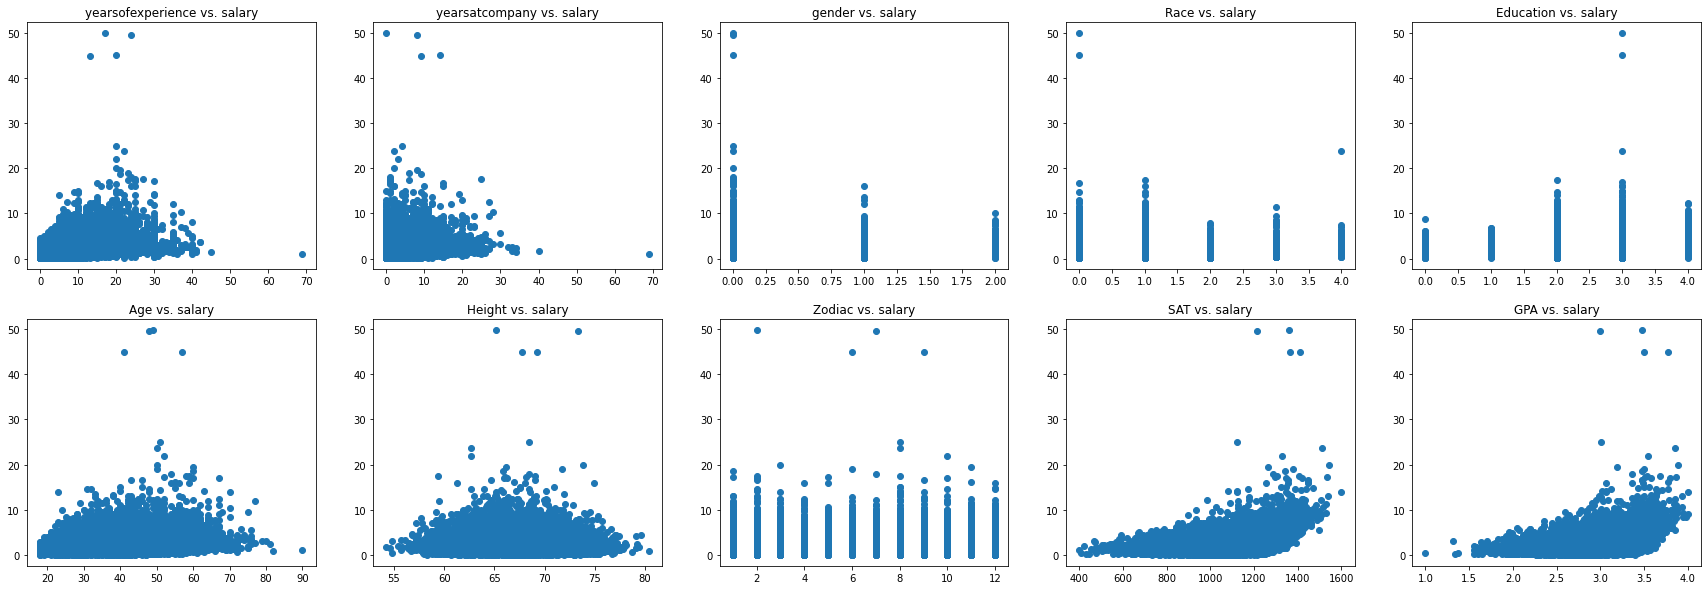

In [6]:
predictors = df.columns.drop(df.columns[7:17]).drop(df.columns[0:4])
fig, axis = plt.subplots(2,5, figsize = (30,10))
z = 0
for ii in range(2):
    for jj in range(5):
        axis[ii,jj].plot(df[predictors[z]], df['totalyearlycompensation'], 'o')
        axis[ii,jj].set_title(predictors[z] + ' vs. salary')
        z+= 1
#plt.plot( df.yearsofexperience,df.totalyearlycompensation, 'o')


# distributions of each predictor

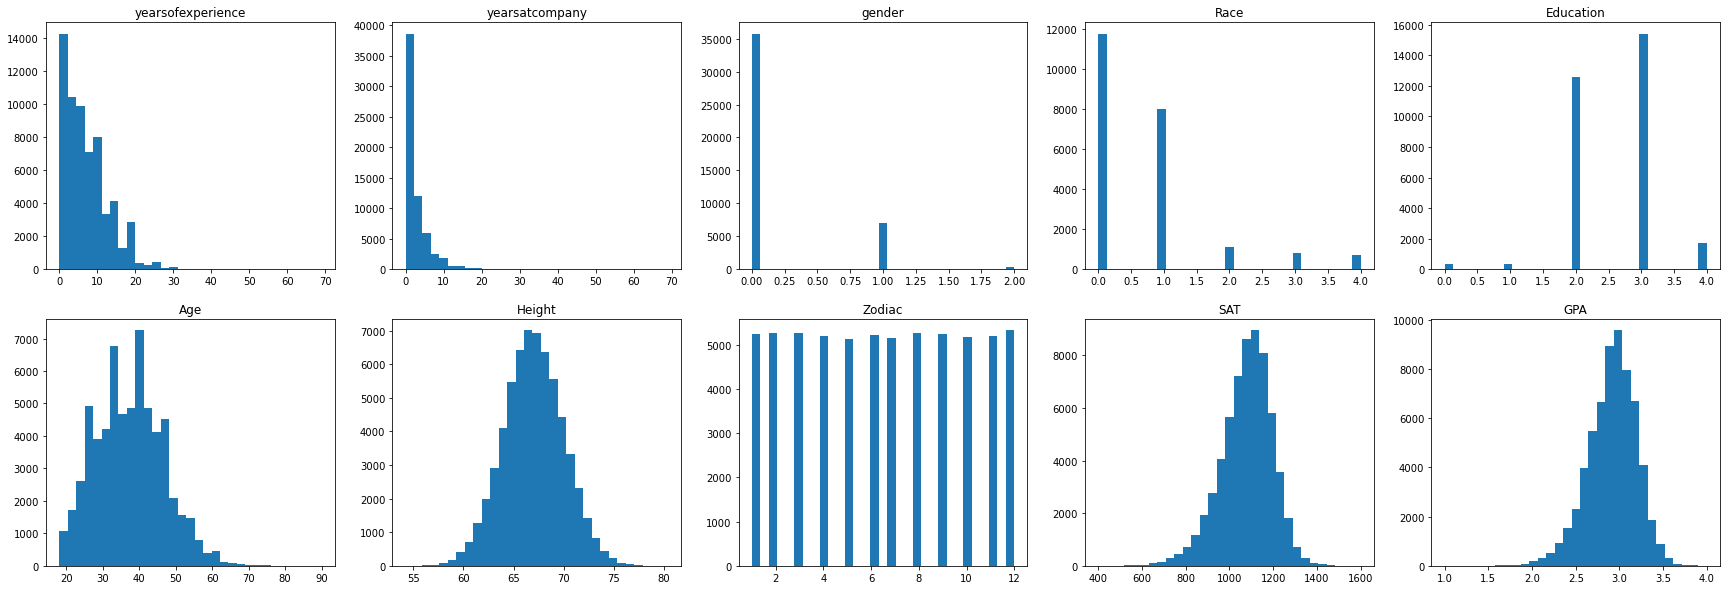

In [19]:
fig, axis = plt.subplots(2,5, figsize = (30,10))
z = 0
for ii in range(2):
    for jj in range(5):
        axis[ii,jj].hist(df[predictors[z]], bins = 31)
        axis[ii,jj].set_title(predictors[z])
        z+= 1

# Question 1: Using multiple linear regression: What is the best predictor of total annual compensation, how much variance is explained by this predictor vs. the full multiple regression model?

In [20]:
# There are too many missing values for gender, race, and education. There is no way to impute for them, so I will drop rows with nan values for the sake of this assignment.
df1 = df.dropna()
df1 = df1.join(pd.get_dummies(df1.gender))
y = df1['totalyearlycompensation']


from scipy import stats
print('Education r: ' + str(stats.spearmanr(df1['Education'], df1['totalyearlycompensation']))) # 0.203

for ii in  df1.columns[11:17]:
    print(ii + " r: " + str(stats.pointbiserialr(df1[ii], df1['totalyearlycompensation'])))

for ii in df1.columns[-3:]:
    print(str(ii) + " r: %f" + str(stats.pointbiserialr(df1[ii], df1['totalyearlycompensation'])))
df1.corr()
df1
# years of experience has the highest correlation: 0.403


Education r: SpearmanrResult(correlation=0.20334447316842666, pvalue=2.889560478406164e-200)
Some_College r: PointbiserialrResult(correlation=0.013544011803469395, pvalue=0.04657811593702333)
Race_Asian r: PointbiserialrResult(correlation=-0.03702750938856211, pvalue=5.258885347711878e-08)
Race_White r: PointbiserialrResult(correlation=0.04655860846375575, pvalue=7.670064083438391e-12)
Race_Two_Or_More r: PointbiserialrResult(correlation=0.01224726715187604, pvalue=0.07192989258232127)
Race_Black r: PointbiserialrResult(correlation=-0.0224992254739376, pvalue=0.0009455860156401143)
Race_Hispanic r: PointbiserialrResult(correlation=-0.010170796524928846, pvalue=0.1350615982098685)
0.0 r: %fPointbiserialrResult(correlation=0.036202076666121796, pvalue=1.0324128002253061e-07)
1.0 r: %fPointbiserialrResult(correlation=-0.039119702117601206, pvalue=8.920717841628273e-09)
2.0 r: %fPointbiserialrResult(correlation=0.013932751078522723, pvalue=0.04063432594211608)


,totalyearlycompensation,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,Age,Height,Zodiac,SAT,GPA,0.0,1.0,2.0
15710,4.00,210000,145000.0,45000.0,5.0,5.0,0.0,0,0,1,0,0,1,0,0,0,0,0.0,4.0,45,68.891,9,1166,3.04,1,0,0
23532,1.36,124000,1000.0,11000.0,3.0,2.0,0.0,0,1,0,0,0,0,0,1,0,0,3.0,2.0,24,61.454,12,1175,3.07,1,0,0
23533,3.37,177000,125000.0,36000.0,6.0,6.0,0.0,0,1,0,0,0,1,0,0,0,0,0.0,2.0,25,65.455,1,1268,3.34,1,0,0
23534,2.22,164000,38000.0,20000.0,4.0,4.0,0.0,1,0,0,0,0,1,0,0,0,0,0.0,3.0,32,73.769,8,1070,2.75,1,0,0
23535,1.87,165000,22000.0,0.0,5.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1.0,2.0,29,68.710,2,1187,3.23,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61981,14.70,290000,1100.0,80000.0,9.0,7.0,0.0,0,1,0,0,0,1,0,0,0,0,0.0,2.0,31,68.402,12,1436,3.77,1,0,0
61982,45.00,450000,3700.0,350000.0,20.0,14.0,0.0,1,0,0,0,0,1,0,0,0,0,0.0,3.0,57,69.195,6,1363,3.50,1,0,0
61984,16.05,250000,1305.0,50000.0,16.0,2.0,1.0,1,0,0,0,0,0,1,0,0,0,1.0,3.0,55,66.902,11,1447,3.77,0,1,0
61987,23.72,315000,1933.0,124000.0,22.0,2.0,0.0,1,0,0,0,0,0,0,0,1,0,4.0,3.0,50,62.691,8,1513,3.85,1,0,0


In [21]:

X = df1.drop(['totalyearlycompensation', 'basesalary','stockgrantvalue','bonus', 'gender','Race','Education'], axis = 1)
y = df1.totalyearlycompensation
mean = X[['yearsofexperience', 'yearsatcompany','Age','Height','Zodiac','SAT','GPA']].mean()
std = X[['yearsofexperience', 'yearsatcompany','Age','Height','Zodiac','SAT','GPA']].std()
X[['yearsofexperience', 'yearsatcompany','Age','Height','Zodiac','SAT','GPA']] = (X[['yearsofexperience', 'yearsatcompany','Age','Height','Zodiac','SAT','GPA']] - mean) / std
#y = (y - y.mean())/ y.std()


In [10]:
z = X.join(y)
z.corr()

,yearsofexperience,yearsatcompany,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Age,Height,Zodiac,SAT,GPA,0.0,1.0,2.0,totalyearlycompensation
yearsofexperience,1.000000,0.537471,0.096770,-0.116457,-0.001713,0.019542,0.068088,-0.102823,0.127921,-0.021302,-0.036058,0.000896,0.630617,-0.010432,-0.004241,0.138850,0.123821,0.061052,-0.060767,-0.005092,0.402683
yearsatcompany,0.537471,1.000000,0.040394,-0.044102,0.009299,-0.010183,0.011381,-0.056818,0.088881,-0.023252,-0.045704,-0.009368,0.338795,-0.008361,0.001061,0.043519,0.036653,0.046121,-0.044373,-0.012268,0.167902
Masters_Degree,0.096770,0.040394,1.000000,-0.863663,-0.180373,-0.101431,-0.107739,0.238370,-0.184024,-0.046974,-0.039084,-0.071458,0.063942,-0.000167,-0.012306,0.031670,0.028665,-0.020096,0.022909,-0.014288,0.098779
Bachelors_Degree,-0.116457,-0.044102,-0.863663,1.000000,-0.214215,-0.120461,-0.127954,-0.182108,0.131104,0.042074,0.040136,0.062153,-0.078929,-0.000741,0.011177,-0.054504,-0.049656,-0.003358,0.002594,0.004387,-0.154913
Doctorate_Degree,-0.001713,0.009299,-0.180373,-0.214215,1.000000,-0.025142,-0.026705,-0.006633,0.020691,-0.010863,-0.020350,-0.005009,0.007123,-0.007168,0.005801,0.048565,0.045482,0.024526,-0.025061,0.001518,0.140402
Highschool,0.019542,-0.010183,-0.101431,-0.120461,-0.025142,1.000000,-0.015017,-0.099808,0.084923,0.013499,0.001767,0.029312,0.005949,0.017350,-0.007462,0.001179,-0.003489,0.036215,-0.043307,0.036862,-0.012521
Some_College,0.068088,0.011381,-0.107739,-0.127954,-0.026705,-0.015017,1.000000,-0.110618,0.091363,0.022100,0.025081,0.014110,0.045677,-0.000988,0.001581,0.013066,0.015242,0.019766,-0.020300,0.001789,0.013544
Race_Asian,-0.102823,-0.056818,0.238370,-0.182108,-0.006633,-0.099808,-0.110618,1.000000,-0.786963,-0.203110,-0.188349,-0.241279,-0.065494,-0.004527,-0.001929,-0.023048,-0.022405,-0.003065,0.011564,-0.046510,-0.037028
Race_White,0.127921,0.088881,-0.184024,0.131104,0.020691,0.084923,0.091363,-0.786963,1.000000,-0.142517,-0.132160,-0.169599,0.080341,0.009771,0.005951,0.021278,0.021202,0.020951,-0.022000,0.004554,0.046559
Race_Two_Or_More,-0.021302,-0.023252,-0.046974,0.042074,-0.010863,0.013499,0.022100,-0.203110,-0.142517,1.000000,-0.034110,-0.043772,-0.020323,0.001792,-0.000789,0.007336,0.010017,-0.028772,0.008051,0.115487,0.012247


In [11]:
ols = LinearRegression()
ols.fit(X, y)
print(ols.score(X,y))

# terrible model: r^2 = 0.267
#model1.coef_
getBetas(X, ols.coef_)

0.2665575126709313


,predictor,beta
0,yearsofexperience,0.517441
1,yearsatcompany,-0.076845
2,Masters_Degree,-0.153472
3,Bachelors_Degree,-0.377440
4,Doctorate_Degree,0.559152
5,Highschool,-0.505484
6,Some_College,-0.431768
7,Race_Asian,0.124396
8,Race_White,0.159724
9,Race_Two_Or_More,0.290619


In [22]:
# Let's see how an actual model performs
def crossVal(model, X, y):
    mse = np.empty(1001)*np.nan
    for ii in tqdm(range(len(mse))):
        XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
        model.fit(XTrain, yTrain)
        error = MSE(yTest, model.predict(XTest))
        mse[ii] = error
        
    return mse


In [16]:
ols = LinearRegression()
cv = crossVal(ols, X, y)
print(np.mean(cv))
print(np.std(cv))
largeOlsMSE = [x for x in cv if x > 10]
largeOlsMSE
# OLS is terrible for this dataset.
# There are some extremely large MSEs

100%|██████████| 1001/1001 [00:10<00:00, 91.73it/s] 

1.3005896180179832
0.2651849310281979


[]

In [1081]:
y

15710     4.00
23532     1.36
23533     3.37
23534     2.22
23535     1.87
         ...  
61981    14.70
61982    45.00
61984    16.05
61987    23.72
61991    49.80
Name: totalyearlycompensation, Length: 21591, dtype: float64

# Question 2: Using ridge regression to do the same as in 1): How does the model change or improve compared to OLS? What is the optimal lambda? 

100%|██████████| 1000/1000 [00:05<00:00, 173.83it/s]


2.8228228228228227


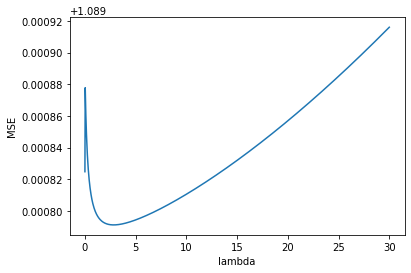

In [949]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)#, random_state = 0)
lambdas = np.linspace(0,30, 1000)
mse = np.empty(len(lambdas)) * np.nan

# running this again will change the model and therefore the optimal lambda, therefore I commented this out

for ii in tqdm(range(len(lambdas))):
    ridgeModel = Ridge(alpha=lambdas[ii]).fit(XTrain, yTrain)
    error = MSE(yTest,ridgeModel.predict(XTest))
    mse[ii] = error
plt.plot(lambdas, mse)
plt.xlabel('lambda')
plt.ylabel('MSE');

rlambda = lambdas[np.argmin(mse)]
print(rlambda)

In [1075]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.920210,0.844414,0.002986,0.001045,0.00001,{'alpha': 1e-05},2.693764e-01,0.303543,0.312788,0.283560,0.191031,0.272060,0.043255,1
1,0.010281,0.001169,0.001995,0.000226,0.03004,{'alpha': 0.03004002002002002},2.616595e-01,0.281788,0.283593,0.262631,0.182767,0.254488,0.037025,2
2,0.008309,0.000168,0.001846,0.000009,0.06007,{'alpha': 0.060070040040040046},2.591713e-01,0.273472,0.270048,0.251642,0.173906,0.245648,0.036702,3
3,0.008283,0.000278,0.001844,0.000005,0.0901,{'alpha': 0.09010006006006006},2.560443e-01,0.265470,0.261751,0.245922,0.166555,0.239148,0.036891,4
4,0.008207,0.000261,0.001840,0.000013,0.12013,{'alpha': 0.12013008008008008},2.537855e-01,0.258341,0.253236,0.240588,0.159767,0.233143,0.037160,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.007713,0.000100,0.002004,0.000293,29.87988,{'alpha': 29.879879919919922},-2.378316e-07,-0.001359,-0.003570,-0.001018,-0.002700,-0.001729,0.001262,20
996,0.007963,0.000231,0.001836,0.000005,29.90991,{'alpha': 29.90990993993994},-2.378316e-07,-0.001359,-0.003570,-0.001018,-0.002700,-0.001729,0.001262,20
997,0.008691,0.001170,0.002056,0.000296,29.93994,{'alpha': 29.93993995995996},-2.378316e-07,-0.001359,-0.003570,-0.001018,-0.002700,-0.001729,0.001262,20
998,0.010065,0.000850,0.002601,0.000248,29.96997,{'alpha': 29.969969979979982},-2.378316e-07,-0.001359,-0.003570,-0.001018,-0.002700,-0.001729,0.001262,20


In [1083]:
# compare ridge with ols
ols = LinearRegression()
ridge = Ridge(alpha = rlambda)
olsMSE = crossVal(ols, X, y)
ridMSE = crossVal(ridge, X, y)
ridge.fit(XTrain, yTrain)


100%|██████████| 1001/1001 [00:10<00:00, 92.33it/s]


Ridge(alpha=2.8228228228228227)

In [1084]:
print('OLS MSE mean: %0.3f, median: %0.3f, std: %0.3f' % (np.mean(olsMSE), np.median(olsMSE), np.std(olsMSE)))
print('Ridge MSE mean: %0.3f, median: %0.3f, std: %0.3f' % (np.mean(ridMSE), np.median(ridMSE), np.std(ridMSE)))
# Ridge is much more consistent

OLS MSE mean: 1458041254025824.000, median: 1.172, std: 44983566266002200.000
Ridge MSE mean: 1.325, median: 1.181, std: 0.275


In [1085]:
betaComparison = getBetas(XTrain, ridge.coef_)
betaComparison['olsBeta'] = (getBetas(XTrain, ols.coef_)['beta'])
betaComparison.columns = ['predictor','ridgeBeta','olsBeta']
betaComparison

,predictor,ridgeBeta,olsBeta
0,yearsofexperience,0.390314,0.522858
1,yearsatcompany,-0.052508,-0.088749
2,Masters_Degree,-0.013866,-0.162629
3,Bachelors_Degree,-0.174918,-0.383194
4,Doctorate_Degree,0.542783,0.528030
5,Highschool,-0.275353,-0.538919
6,Some_College,-0.192773,-0.456025
7,Race_Asian,-0.022079,0.132006
8,Race_White,0.004914,0.170651
9,Race_Two_Or_More,0.105754,0.303327


In [ ]:
# Ridge is much more consistent than ols

In [926]:
ridgeBetas = getBetas(XTest, ols.coef_)

,predictor,beta
0,yearsofexperience,52.438139
1,yearsatcompany,-7.944003
2,Masters_Degree,-5.028619
3,Bachelors_Degree,-26.634873
4,Doctorate_Degree,68.262447
5,Highschool,-41.285358
6,Some_College,-34.837520
7,Race_Asian,11.547609
8,Race_White,15.273023
9,Race_Two_Or_More,27.827274


# Question 3: Using Lasso regression to do the same as in 1): How does the model change now? How many of the predictor betas are shrunk to exactly 0? What is the optimal lambda now?

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/a/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.56057019864238, tolerance: 1.5722588456875914
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 1000/1000 [00:06<00:00, 143.40it/s]


1e-05


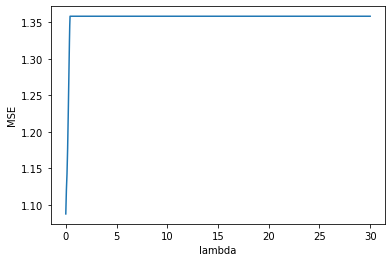

In [1067]:
# Sklearn requires data for Lasso to be centered. I have done that with X, now do it to y
yn = (y-y.mean())/y.std()

XTrain, XTest, yTrain, yTest = train_test_split(X, yn, test_size = 0.2)#, random_state = 0)
lambdas = np.linspace(1e-5,30, 1000)
mse = np.empty(len(lambdas)) * np.nan

# running this again will change the model and therefore the optimal lambda, therefore I commented this out

for ii in tqdm(range(len(lambdas))):
    lass = Lasso(alpha=lambdas[ii]).fit(XTrain, yTrain)
    error = MSE(yTest,lass.predict(XTest))
    mse[ii] = error
plt.plot(lambdas, mse)
plt.xlabel('lambda')
plt.ylabel('MSE');

llambda = lambdas[np.argmin(mse)]
print(llambda)

In [1072]:
# Grid search to confirm the best lambda
lasso = Lasso(random_state = 0, max_iter = 10000)
alphas = np.linspace(1e-5, 30, 1000)
paramTuning = {'alpha': alphas}
clf = GridSearchCV(lasso, paramTuning, cv = 5, refit = False)
clf.fit(X, y)
clf.best_params_

/Users/a/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.197417264025717, tolerance: 3.143967624976553
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1e-05}

In [1077]:
lasso = Lasso(alpha = llambda, max_iter = 10000)
lasMSE = crossVal(lasso, X, y)

In [1169]:
print('OLS MSE mean: %0.3f, std: %0.3f' % (np.mean(olsMSE), np.std(olsMSE)))
print('Lasso MSE mean: %0.3f, std: %0.3f' % (np.mean(lasMSE), np.std(lasMSE)))

OLS MSE mean: 1458041254025824.000, std: 44983566266002200.000
Lasso MSE mean: 1.299, std: 0.262


In [1087]:
betaComparison = getBetas(XTrain, lasso.coef_)
betaComparison['olsBeta'] = (getBetas(XTrain, ols.coef_)['beta'])
betaComparison.columns = ['predictor','lassoBeta','olsBeta']
betaComparison

,predictor,lassoBeta,olsBeta
0,yearsofexperience,0.514652,0.521562
1,yearsatcompany,-0.080931,-0.075527
2,Masters_Degree,0.216790,-0.029444
3,Bachelors_Degree,-0.000000,-0.249831
4,Doctorate_Degree,0.906597,0.656479
5,Highschool,-0.051745,-0.332724
6,Some_College,-0.030740,-0.268425
7,Race_Asian,-0.019224,0.120452
8,Race_White,0.029967,0.158773
9,Race_Two_Or_More,0.150170,0.279269


# Question 4: There is controversy as to the existence of a male/female gender pay gap in tech job compensation. Build a logistic regression model (with gender as the outcome variable) to see if there is an appreciable beta associated with total annual compensation with and without controlling for other factors. 

In [24]:
# Convert annual compensation into categorical
medianIncome = df.totalyearlycompensation.median()
df4 = df.copy().drop(['basesalary','stockgrantvalue','bonus'], axis = 1)
#df4['totalyearlycompensation'] = [1  if x >= medianIncome else 0 for x in df['totalyearlycompensation']]

In [1088]:
X

,yearsofexperience,yearsatcompany,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Age,Height,Zodiac,SAT,GPA,0.0,1.0,2.0
15710,-0.362903,0.690742,0,0,1,0,0,1,0,0,0,0,0.845898,0.630954,0.730794,0.798852,0.493145,1,0,0
23532,-0.704935,-0.211540,0,1,0,0,0,0,0,1,0,0,-1.419143,-1.845122,1.600425,0.875489,0.600912,1,0,0
23533,-0.191887,0.991503,0,1,0,0,0,1,0,0,0,0,-1.311284,-0.513029,-1.588221,1.667397,1.570813,1,0,0
23534,-0.533919,0.389982,1,0,0,0,0,1,0,0,0,0,-0.556270,2.255036,0.440917,-0.018602,-0.548600,1,0,0
23535,-0.362903,-0.813061,0,1,0,0,0,0,1,0,0,0,-0.879847,0.570692,-1.298344,0.977670,1.175668,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61981,0.321161,1.292264,0,1,0,0,0,1,0,0,0,0,-0.664129,0.468146,1.600425,3.097941,3.115469,1,0,0
61982,2.202336,3.397589,1,0,0,0,0,1,0,0,0,0,2.140206,0.732168,-0.138836,2.476336,2.145568,1,0,0
61984,1.518272,-0.211540,1,0,0,0,0,0,1,0,0,0,1.924488,-0.031264,1.310548,3.191608,3.115469,0,1,0
61987,2.544368,-0.211540,1,0,0,0,0,0,0,0,1,0,1.385193,-1.433275,0.440917,3.753607,3.402847,1,0,0


## First, contolling for other variables, meaning that using total yearly compensation as the only predictor
# Also, drop "other" since this question only concerns male and female

In [25]:
df4 = df.loc[df['gender'] != 2.0]

payAndGenderDf = df4[['totalyearlycompensation','gender']].dropna()
y = payAndGenderDf.gender
x = payAndGenderDf.totalyearlycompensation

df4

,totalyearlycompensation,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,Age,Height,Zodiac,SAT,GPA
0,1.27,107000,20000.0,10000.0,1.5,1.5,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,38,68.590,5,829,2.13
1,1.00,0,0.0,0.0,5.0,3.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,34,68.059,7,993,2.77
2,3.10,155000,0.0,0.0,8.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,42,61.343,3,1200,3.26
3,3.72,157000,180000.0,35000.0,7.0,5.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,28,66.495,3,1170,3.07
4,1.57,0,0.0,0.0,5.0,3.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,34,69.015,2,1115,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,3.27,155000,150000.0,22000.0,10.0,1.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,52,64.792,6,1064,2.76
62638,2.37,146900,73200.0,16000.0,2.0,2.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,21,69.483,9,1160,3.27
62639,2.20,157000,25000.0,20000.0,14.0,12.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,43,62.331,12,1014,2.78
62640,2.80,194688,57000.0,29000.0,8.0,4.0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,NaN,48,70.357,10,1109,3.04


In [26]:
logi = LogisticRegression()
#logi.fit(xTrain.values.reshape(-1,1),yTrain)
logi.fit(x.values.reshape(-1,1),y)
logi.coef_ # -0.001
# Having high income, the log odds of the person being female is -0.267. 
# In other words, having higher income means that the probability that the person is female is lower than that of the person being male

array([[-0.11491161]])

In [27]:
# See if the model works:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
xTrain, xTest, yTrain, yTest = train_test_split(x,y, test_size = 0.2)
logi = LogisticRegression()
#logi.fit(xTrain.values.reshape(-1,1),yTrain)
logi.fit(xTrain.values.reshape(-1,1),yTrain)
pred = logi.predict_proba(xTest.values.reshape(-1,1))[:,1]
logiAuc = roc_auc_score(yTest, pred)
print(logiAuc)
logi.coef_

0.5168123724150173


array([[-0.12783432]])

In [1157]:
X

,yearsofexperience,yearsatcompany,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Age,Height,Zodiac,SAT,GPA,0.0,1.0,2.0
15710,-0.362903,0.690742,0,0,1,0,0,1,0,0,0,0,0.845898,0.630954,0.730794,0.798852,0.493145,1,0,0
23532,-0.704935,-0.211540,0,1,0,0,0,0,0,1,0,0,-1.419143,-1.845122,1.600425,0.875489,0.600912,1,0,0
23533,-0.191887,0.991503,0,1,0,0,0,1,0,0,0,0,-1.311284,-0.513029,-1.588221,1.667397,1.570813,1,0,0
23534,-0.533919,0.389982,1,0,0,0,0,1,0,0,0,0,-0.556270,2.255036,0.440917,-0.018602,-0.548600,1,0,0
23535,-0.362903,-0.813061,0,1,0,0,0,0,1,0,0,0,-0.879847,0.570692,-1.298344,0.977670,1.175668,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61981,0.321161,1.292264,0,1,0,0,0,1,0,0,0,0,-0.664129,0.468146,1.600425,3.097941,3.115469,1,0,0
61982,2.202336,3.397589,1,0,0,0,0,1,0,0,0,0,2.140206,0.732168,-0.138836,2.476336,2.145568,1,0,0
61984,1.518272,-0.211540,1,0,0,0,0,0,1,0,0,0,1.924488,-0.031264,1.310548,3.191608,3.115469,0,1,0
61987,2.544368,-0.211540,1,0,0,0,0,0,0,0,1,0,1.385193,-1.433275,0.440917,3.753607,3.402847,1,0,0


In [1160]:
# include more variables (the ones that seem to "matter")
temp = df4[['totalyearlycompensation','yearsofexperience', 'Education', 'Age', 'SAT', 'GPA', 'gender']].copy().dropna()
temp = temp[temp.gender != 2]
x = temp[['totalyearlycompensation','yearsofexperience', 'Education', 'Age', 'SAT', 'GPA']]
y = temp.gender
logi = LogisticRegression()
logi.fit(x, y)
logi.coef_
logiCoefs = pd.DataFrame(columns = ['feature', 'beta'])
logiCoefs.feature = x.columns
logiCoefs.beta = logi.coef_[0]
logi.coef_


array([[-0.01828645, -0.02380492, -0.07174397, -0.00653771, -0.00052362,
        -0.06706756]])

In [1161]:
logiCoefs.sort_values(by = 'beta', key = abs, ascending = False)

,feature,beta
2,Education,-0.071744
5,GPA,-0.067068
1,yearsofexperience,-0.023805
0,totalyearlycompensation,-0.018286
3,Age,-0.006538
4,SAT,-0.000524


# Question 5: Build a logistic regression model to see if you can predict high and low pay from years of relevant experience, age, height, SAT score and GPA, respectively.

In [29]:
df5 = df[df['gender'] != 2]
df5 = df[['totalyearlycompensation', 'yearsofexperience','Age','Height','SAT','GPA','gender']]
df5 = df5.dropna()
medianIncome = df5.totalyearlycompensation.median()
df5['totalyearlycompensation'] = [1  if x >= medianIncome else 0 for x in df5['totalyearlycompensation']]
df5

,totalyearlycompensation,yearsofexperience,Age,Height,SAT,GPA,gender
264,0,4.0,27,65.140,999,2.80,0.0
265,0,12.0,47,64.706,1122,3.09,0.0
266,1,7.0,28,69.016,1244,3.34,0.0
269,0,4.0,36,66.899,1114,3.02,0.0
270,1,11.0,49,65.522,1217,3.30,0.0
...,...,...,...,...,...,...,...
62610,0,1.0,19,69.389,1166,3.13,0.0
62611,1,14.0,54,65.415,1258,3.34,0.0
62612,1,20.0,46,66.600,1173,3.07,1.0
62613,0,3.0,22,64.789,1134,3.13,0.0


In [32]:
X = df5.drop('totalyearlycompensation', axis = 1)
y = df5.totalyearlycompensation
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
logi = LogisticRegression()
logi.fit(XTrain, yTrain)
logi.score(XTest, yTest)
pred = logi.predict(XTest)
#pred = logi.predict_proba(XTest)[:,1]
logiAuc = roc_auc_score(yTest, pred)
print(logiAuc)
getBetas(XTest, logi.coef_[0])

0.668842482395712


,predictor,beta
0,yearsofexperience,0.144709
1,Age,-0.006708
2,Height,-0.063066
3,SAT,0.003249
4,GPA,-0.000939
5,gender,-0.001615


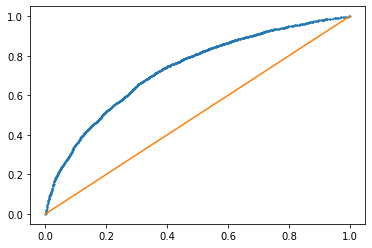

In [33]:
fpr, tpr, _ = roc_curve(yTest, logi.predict_proba(XTest)[:,1])
plt.plot(fpr, tpr, 'o', markersize = 0.5)
plt.plot([0,1], [0,1])
#logi.predict_proba(XTest)

In [450]:
# with individual predictors
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
allLogi = pd.DataFrame(columns = ['Beta', 'AUC'])
for ii in X.columns:
    logi = LogisticRegression().fit(XTrain[ii].values.reshape(-1,1), yTrain)
    auc = roc_auc_score(yTest, logi.predict(XTest[ii].values.reshape(-1,1)))
    allLogi.loc[ii] = [logi.coef_[0,0], auc]
    
allLogi

,Beta,AUC
yearsofexperience,0.153003,0.667881
Age,0.051647,0.585103
Height,0.000129,0.500000
SAT,0.000056,0.500000
GPA,1.677976,0.594480


# EC (a): Is salary, height or age normally distributed? Does this surprise you? Why or why not?

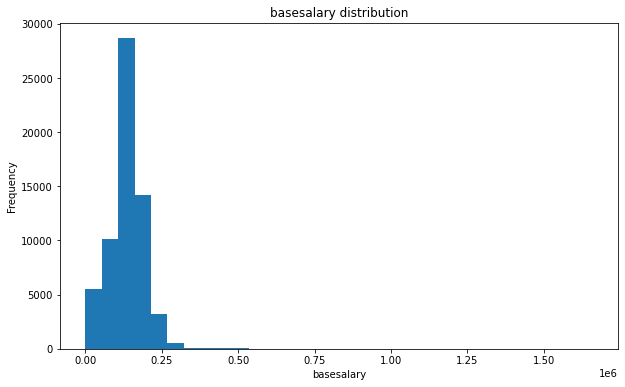

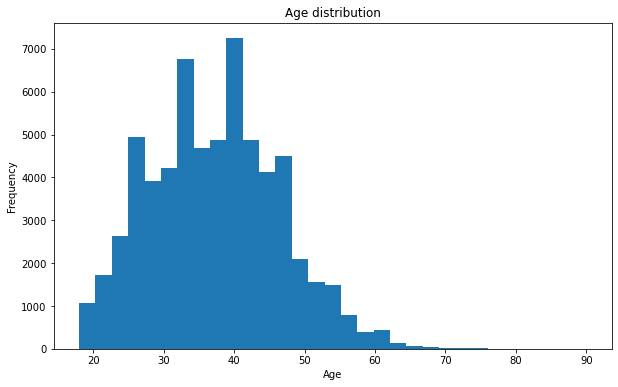

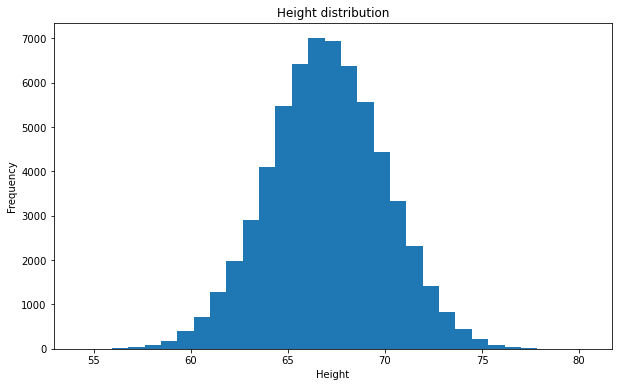

In [630]:
for ii in ['basesalary', 'Age', 'Height']:
    plt.figure(figsize = (10,6))
    plt.hist(df[ii], bins = 31)
    plt.xlabel(ii)
    plt.ylabel('Frequency')
    plt.title(ii + ' distribution')
    plt.savefig(ii + '.jpg')
    plt.show()
    
#plt.hist(df1.Height, bins = 30)

In [188]:
def dedupe_channels(channels):
    # Write your code here
    releventWords = ['Email', 'In-App Message', 'Push','Content Card', 'SMS']
    words = channels.split(', ')
    for ii in words:
        if ii not in releventWords:
            words.remove(ii)
            
    words = set(words)
    words = ', '.join(words)
    
    return words
    

In [190]:
sample = '1, Email, Email, Push, Content Card'
dedupe_channels(sample)

'Content Card, Push, Email'

# EC (b) Tell us something interesting about this dataset that is not already covered by the questions above and that is not obvious.


In [614]:
# perhaps see what race has the highest education level?
raceDf = df.dropna(subset = ['Race'])
raceDf = raceDf.dropna(subset = ['Education'])
races = ['Asian', 'White', 'Hispanic','Mixed','Black']
raceDf['totalyearlycompensation'] =  [1  if x >= medianIncome else 0 for x in raceDf['totalyearlycompensation']]
raceDf = raceDf.drop(raceDf.columns[6:17], axis = 1)
raceDf = raceDf.drop(['bonus', 'basesalary','stockgrantvalue'], axis = 1)
#('Asian', 0)
#('White', 1)
#('Hispanic', 2)
#('Two Or More', 3)
#('Black', 4)
raceDf
raceDf.columns[1:]

Index(['yearsofexperience', 'yearsatcompany', 'Race', 'Education', 'Age',
       'Height', 'Zodiac', 'SAT', 'GPA'],
      dtype='object')

In [615]:
dic = {}
for ii in range(len(races)):
    dic[races[ii]] = raceDf[raceDf.Race == ii].drop(['yearsatcompany','Race', 'Zodiac'], axis = 1)#[['totalyearlycompensation','Education']]
    

for ii in races:
    print(ii + ' Median Education: %.f, Median salary: %f' % (dic[ii].Education.median(), dic[ii].totalyearlycompensation.median()))

Asian Median Education: 3, Median salary: 0.000000
White Median Education: 2, Median salary: 0.000000
Hispanic Median Education: 2, Median salary: 0.000000
Mixed Median Education: 2, Median salary: 0.000000
Black Median Education: 2, Median salary: 0.000000


IndexError: list index out of range

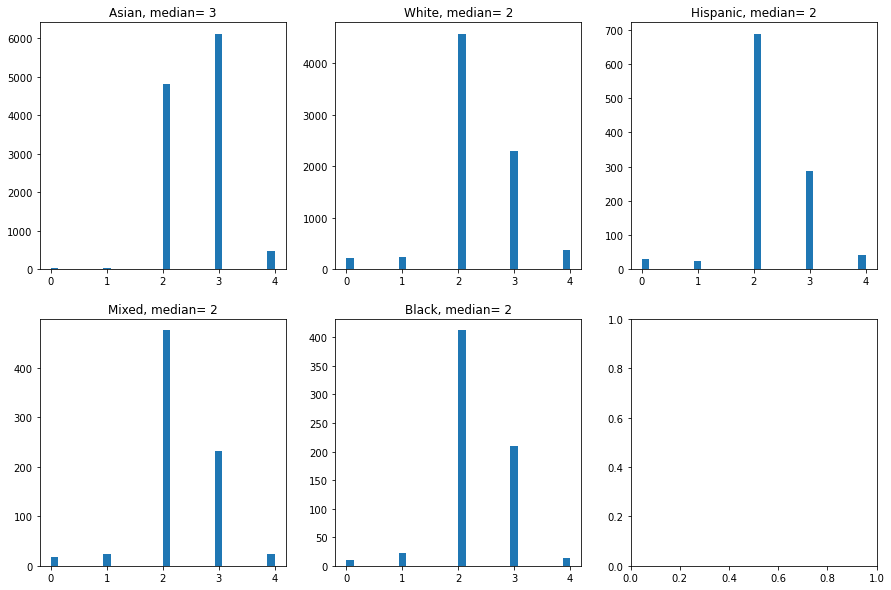

In [616]:
'''for ii in races:
    plt.figure(figsize =(10,6))
    plt.hist(dic[ii].Education, bins = 30)
    plt.title(ii + ' median: %d' %dic[ii].Education.median())'''
    
fig, axis = plt.subplots(2,3, figsize = (15,10))
z = 0
for ii in range(2):
    for jj in range(3):
        axis[ii,jj].hist(dic[races[z]].Education, bins = 30)
        axis[ii,jj].set_title(races[z] + ', median= %d' % dic[races[z]].Education.median())
        z+= 1

In [627]:
# Asian people has the highest median education level
# let's now see if education's association with salary is the same for all races:
racesLogi = pd.DataFrame(columns = races, index = dic['Asian'].columns[1:].tolist())

racesLogi.loc['AUC'] = [np.nan] * 5
#racesLogi.set_axis(raceDf.columns[1:], axis = 0)
for ii in races:
    x = dic[ii].drop('totalyearlycompensation', axis = 1)
    y = dic[ii].totalyearlycompensation
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2)
    logi = LogisticRegression().fit(xTrain, yTrain)
    auc = roc_auc_score(yTest, logi.predict(xTest))
    racesLogi[ii] = np.append(logi.coef_[0], auc)
    #racesLogi.loc[ii, 'AUC'] = auc
    
racesLogi


/Users/a/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/a/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

,Asian,White,Hispanic,Mixed,Black
yearsofexperience,0.131284,0.133003,0.122491,0.162579,0.139827
Education,0.698454,0.316902,0.182559,0.430228,0.317380
Age,-0.005925,0.004171,-0.010232,-0.004704,0.005820
Height,-0.049839,-0.032249,-0.035511,0.008189,-0.083609
SAT,0.005812,0.005042,0.006139,0.005823,0.001105
GPA,-1.131416,-0.841386,-1.552662,-0.600755,1.029000
AUC,0.672525,0.714011,0.711858,0.721714,0.676969


In [629]:
df5 = df[df['gender'] != 2]
df5 = df[['totalyearlycompensation', 'yearsofexperience','Education','Age','Height','SAT','GPA']]
df5 = df5.dropna()
medianIncome = df5.totalyearlycompensation.median()
df5['totalyearlycompensation'] = [1  if x >= medianIncome else 0 for x in df5['totalyearlycompensation']]
X = df5.drop('totalyearlycompensation', axis = 1)
y = df5.totalyearlycompensation
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)
logi = LogisticRegression()
logi.fit(XTrain, yTrain)
logi.score(XTest, yTest)
pred = logi.predict(XTest)
logiAuc = roc_auc_score(yTest, pred)
print(logiAuc)
getBetas(XTest, logi.coef_[0])

0.6860694704105603


,predictor,beta
0,yearsofexperience,0.133780
1,Education,0.576846
2,Age,-0.008363
3,Height,-0.079651
4,SAT,0.003098
5,GPA,-0.010098


# PCA

In [8]:


# preliminary data processing

df = pd.read_csv('techSalaries2017.csv')
df = df[df.gender != 'Title: Senior Software Engineer'].fillna(-1)
df = df.replace(-1, np.nan)
df = df.drop(['company', 'title', 'location'], axis = 1).dropna()
# Scale totalyearly compensation
df['totalyearlycompensation'] /= 100000

# convert catagorical to numeric
df['gender'] = df.gender.replace("Male", 0).replace('Female', 1).replace('Other', 2)
df['Race'] = df['Race'].replace('Asian', 0).replace('White', 1).replace('Hispanic', 2).replace('Two Or More', 3).replace('Black', 4)
df['Education'] = df['Education'].replace('Highschool', 0).replace('Some College', 1).replace('Bachelor\'s Degree', 2).replace('Master\'s Degree', 3).replace('PhD', 4) # ordinal
df

,totalyearlycompensation,basesalary,stockgrantvalue,bonus,yearsofexperience,yearsatcompany,gender,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education,Age,Height,Zodiac,SAT,GPA
15710,4.00,210000,145000.0,45000.0,5.0,5.0,0,0,0,1,0,0,1,0,0,0,0,0,4,45,68.891,9,1166,3.04
23532,1.36,124000,1000.0,11000.0,3.0,2.0,0,0,1,0,0,0,0,0,1,0,0,3,2,24,61.454,12,1175,3.07
23533,3.37,177000,125000.0,36000.0,6.0,6.0,0,0,1,0,0,0,1,0,0,0,0,0,2,25,65.455,1,1268,3.34
23534,2.22,164000,38000.0,20000.0,4.0,4.0,0,1,0,0,0,0,1,0,0,0,0,0,3,32,73.769,8,1070,2.75
23535,1.87,165000,22000.0,0.0,5.0,0.0,0,0,1,0,0,0,0,1,0,0,0,1,2,29,68.710,2,1187,3.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61981,14.70,290000,1100.0,80000.0,9.0,7.0,0,0,1,0,0,0,1,0,0,0,0,0,2,31,68.402,12,1436,3.77
61982,45.00,450000,3700.0,350000.0,20.0,14.0,0,1,0,0,0,0,1,0,0,0,0,0,3,57,69.195,6,1363,3.50
61984,16.05,250000,1305.0,50000.0,16.0,2.0,1,1,0,0,0,0,0,1,0,0,0,1,3,55,66.902,11,1447,3.77
61987,23.72,315000,1933.0,124000.0,22.0,2.0,0,1,0,0,0,0,0,0,0,1,0,4,3,50,62.691,8,1513,3.85


In [42]:
from sklearn.decomposition import PCA
from scipy import stats
X = df.drop(['totalyearlycompensation','bonus','basesalary','stockgrantvalue','Zodiac','Race','Education'], axis = 1)
X = pd.get_dummies(X, columns = ['gender'])
y = df.totalyearlycompensation
X[X.columns[2:12]] /= X[X.columns[2:12]].sum()/(len(X[X.columns[2:12]]) ** 1/2)
X[X.columns[16:20]] /= X[X.columns[16:20]].sum()/len(X[X.columns[16:20]] ** 1/2)
#X[['yearsofexperience','yearsatcompany','Age','Height','SAT','GPA']] = (X[['yearsofexperience','yearsatcompany','Age','Height','SAT','GPA']] - X[['yearsofexperience','yearsatcompany','Age','Height','SAT','GPA']].mean())/X[['yearsofexperience','yearsatcompany','Age','Height','SAT','GPA']].std(ddof = 0)
X = (X - X.mean())/ X.std(ddof = 0)
X

,yearsofexperience,yearsatcompany,Masters_Degree,Bachelors_Degree,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Age,Height,SAT,GPA,gender_0,gender_1,gender_2
15710,-0.362911,0.690758,-0.853050,-1.013100,4.729364,-0.118904,-0.126299,0.944259,-0.743097,-0.191788,-0.177850,-0.228233,0.845917,0.630969,0.798871,0.493157,0.475829,-0.468052,-0.07024
23532,-0.704951,-0.211545,-0.853050,0.987069,-0.211445,-0.118904,-0.126299,-1.059032,-0.743097,5.214085,-0.177850,-0.228233,-1.419175,-1.845165,0.875509,0.600926,0.475829,-0.468052,-0.07024
23533,-0.191891,0.991526,-0.853050,0.987069,-0.211445,-0.118904,-0.126299,0.944259,-0.743097,-0.191788,-0.177850,-0.228233,-1.311314,-0.513040,1.667436,1.570849,0.475829,-0.468052,-0.07024
23534,-0.533931,0.389991,1.172264,-1.013100,-0.211445,-0.118904,-0.126299,0.944259,-0.743097,-0.191788,-0.177850,-0.228233,-0.556283,2.255089,-0.018602,-0.548613,0.475829,-0.468052,-0.07024
23535,-0.362911,-0.813080,-0.853050,0.987069,-0.211445,-0.118904,-0.126299,-1.059032,1.345720,-0.191788,-0.177850,-0.228233,-0.879868,0.570705,0.977693,1.175695,0.475829,-0.468052,-0.07024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61981,0.321168,1.292294,-0.853050,0.987069,-0.211445,-0.118904,-0.126299,0.944259,-0.743097,-0.191788,-0.177850,-0.228233,-0.664145,0.468157,3.098013,3.115541,0.475829,-0.468052,-0.07024
61982,2.202387,3.397667,1.172264,-1.013100,-0.211445,-0.118904,-0.126299,0.944259,-0.743097,-0.191788,-0.177850,-0.228233,2.140256,0.732185,2.476393,2.145618,0.475829,-0.468052,-0.07024
61984,1.518307,-0.211545,1.172264,-1.013100,-0.211445,-0.118904,-0.126299,-1.059032,1.345720,-0.191788,-0.177850,-0.228233,1.924533,-0.031265,3.191682,3.115541,-2.101597,2.136514,-0.07024
61987,2.544427,-0.211545,1.172264,-1.013100,-0.211445,-0.118904,-0.126299,-1.059032,-0.743097,-0.191788,5.622704,-0.228233,1.385225,-1.433308,3.753694,3.402926,0.475829,-0.468052,-0.07024


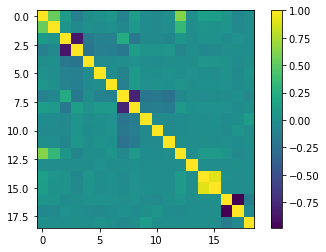

In [43]:
# Overview of collinearity
corrMatrix = np.corrcoef(X, rowvar = False)
plt.imshow(corrMatrix)
plt.colorbar()

In [75]:
pca = PCA().fit(X)
XRotated = pca.transform(X)
eigenV = pca.explained_variance_
components = pca.components_
exaplainedVRation = pca.explained_variance_ratio_
pd.DataFrame(data = components)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,4.923981e-01,3.708348e-01,1.001800e-01,-1.515942e-01,4.896685e-02,4.739432e-02,8.747867e-02,-1.672622e-01,2.013035e-01,-2.632252e-02,-4.622959e-02,-2.435345e-04,4.214487e-01,-1.057747e-02,3.363269e-01,3.293974e-01,0.228421,-0.226449,-2.404524e-02
1,-2.565452e-02,-4.182543e-03,-5.336430e-01,4.951204e-01,-6.162182e-03,7.175965e-02,7.112358e-02,-4.893224e-01,4.221084e-01,6.650705e-02,5.518994e-02,9.391682e-02,-2.517657e-02,5.417334e-03,-7.905789e-02,-7.742602e-02,0.072459,-0.078700,3.009476e-02
2,8.438183e-02,4.630351e-02,-1.671182e-02,2.043879e-02,-7.341856e-03,-2.463559e-02,1.913913e-02,-1.372681e-01,1.084763e-01,4.762836e-02,5.742130e-02,-9.852974e-03,7.656711e-02,6.655767e-03,2.481139e-01,2.488558e-01,-0.643165,0.634194,8.647998e-02
3,2.926342e-01,2.905059e-01,1.449325e-01,-1.313666e-01,-6.798808e-02,1.809117e-02,4.628501e-02,-8.537317e-02,1.264190e-01,-3.964800e-02,-3.537193e-02,-2.080444e-02,2.755357e-01,2.995388e-03,-5.596596e-01,-5.647763e-01,-0.158017,0.157768,1.050980e-02
4,-2.161439e-01,-2.579643e-01,3.482220e-01,-4.904920e-01,9.860937e-02,2.491483e-01,1.948706e-01,-4.075543e-01,4.185139e-01,4.600785e-02,3.384200e-02,-5.213313e-02,-2.374036e-01,4.244598e-02,-6.012583e-03,-4.495723e-03,0.026376,-0.042102,8.485930e-02
5,6.000300e-02,1.426035e-02,1.762839e-02,-3.297734e-02,-1.090539e-01,1.647023e-01,8.421158e-02,-9.860952e-02,-3.399393e-01,6.508604e-01,1.229322e-01,3.246467e-01,6.475125e-02,4.816841e-03,-1.594901e-02,-1.816117e-02,-0.002964,-0.090931,5.159455e-01
6,-4.919718e-03,5.913229e-02,-1.267015e-01,1.594672e-02,3.695664e-01,2.711422e-02,-1.881626e-01,1.639932e-01,1.534746e-01,2.639279e-01,-5.213238e-01,-5.272352e-01,-2.261532e-02,9.330614e-02,-1.505453e-02,-1.430627e-02,-0.030321,-0.033946,3.547813e-01
7,4.431793e-03,1.313084e-02,-2.038306e-01,-1.562369e-01,7.722450e-01,1.231083e-01,6.356369e-02,1.242512e-02,-1.406592e-01,-1.480800e-01,-9.795359e-02,4.863230e-01,2.759805e-02,-1.234823e-01,-4.012254e-02,-4.498726e-02,-0.045568,0.059065,-7.150136e-02
8,1.635631e-02,-5.223467e-04,-1.000265e-01,-4.682210e-02,3.112524e-01,-3.967002e-01,4.525616e-01,1.332387e-02,-7.633127e-02,1.805949e-01,5.163391e-01,-4.269778e-01,3.243126e-02,-1.890736e-01,-3.574555e-02,-3.262208e-02,0.027591,-0.023976,-2.145399e-02
9,4.482599e-02,3.498019e-02,-1.068585e-01,-8.451355e-03,1.615479e-01,4.367314e-01,-2.169687e-01,5.882233e-02,-1.003863e-01,-1.305974e-01,4.977736e-01,-1.980998e-01,6.439902e-02,6.313682e-01,-7.570064e-03,-1.204749e-02,-0.000212,-0.004791,2.749041e-02


<BarContainer object of 19 artists>

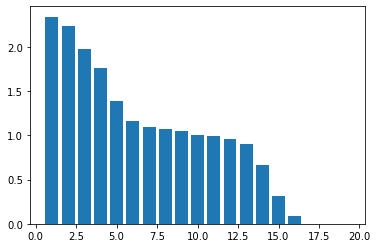

In [49]:
plt.bar(np.linspace(1, len(eigenV), len(eigenV)), eigenV)

Text(0, 0.5, 'cumulative explained variance')

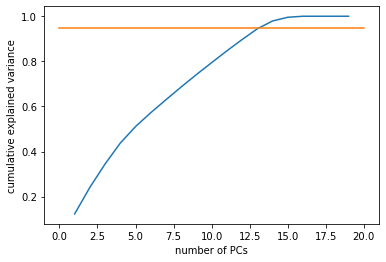

In [56]:
temp = np.cumsum(exaplainedVRation)
plt.plot(np.linspace(1, len(eigenV), len(eigenV)), temp)
plt.plot([0,20],[0.95,0.95])
plt.xlabel('number of PCs')
plt.ylabel('cumulative explained variance')

In [82]:
numPCs = len([x for x in temp if x < 0.95])
numPCs
X.columns.to_list()

['yearsofexperience',
 'yearsatcompany',
 'Masters_Degree',
 'Bachelors_Degree',
 'Doctorate_Degree',
 'Highschool',
 'Some_College',
 'Race_Asian',
 'Race_White',
 'Race_Two_Or_More',
 'Race_Black',
 'Race_Hispanic',
 'Age',
 'Height',
 'SAT',
 'GPA',
 'gender_0',
 'gender_1',
 'gender_2']

## Interpreting PCs

,PC8
Race_Black,0.516339
Some_College,0.452562
Race_Hispanic,0.426978
Highschool,0.396700
Doctorate_Degree,0.311252
Height,0.189074
Race_Two_Or_More,0.180595
Masters_Degree,0.100027
Race_White,0.076331
Bachelors_Degree,0.046822


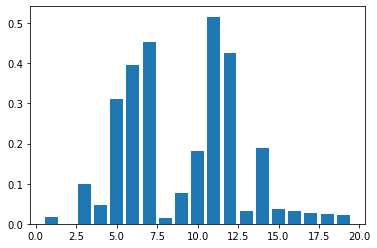

In [106]:
# Each row is a PC
xAxis = X.columns.to_list()
def unlockPC(pcIndex):
   # xAxis = X.columns.to_list()
    plt.bar(np.linspace(1,len(components[pcIndex]),len(components[pcIndex])), abs(components[pcIndex]))
    #plt.xticks(np.linspace(1,len(components[pcIndex]),len(components[pcIndex])), labels = xAxis
    return pd.DataFrame(abs(components[pcIndex]), index = X.columns, columns = ['PC'+str(pcIndex)]).sort_values('PC'+str(pcIndex), ascending = False)
    
unlockPC(8)
#xAxis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.492325,0.370882,0.100266,-0.151725,0.049581,0.046929,0.087103,-0.167398,0.201438,-0.026224,-0.046089,-0.000423,0.421362,-0.010349,0.336320,0.329393,0.228479,-0.226395,-0.024660
1,-0.025658,-0.006059,-0.533513,0.495039,-0.004856,0.071108,0.069421,-0.489669,0.422519,0.066532,0.055655,0.093415,-0.023806,0.005506,-0.078963,-0.077333,0.072699,-0.078782,0.029213
